In [1]:
from huggingface_hub import login

In [2]:
# login()

In [3]:
import locale
def getpreferredencoding(do_setlocale = True):
  return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [4]:
from langchain_community.llms import HuggingFaceHub
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler
from langchain_core.prompts import PromptTemplate
import os
from dotenv import load_dotenv
#
n_gpu_layers = -1  # The number of layers to put on the GPU. The rest will be on the CPU. If you don't know how many layers there are, you can use -1 to move all to GPU.
n_batch = 512  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
#
# Callbacks support token-wise streaming
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

load_dotenv()

# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

huggingface_api_token = os.getenv('huggingface_api_token')

# Make sure the model path is correct for your system!
model = HuggingFaceHub(
    huggingfacehub_api_token=huggingface_api_token,
    repo_id="mistralai/Mistral-7B-Instruct-v0.2",  # You can change this to any model you want to use
    model_kwargs={
        "temperature": 0.75,
        "max_new_tokens": 1000,
        "top_p": 0.99,
    }
)

C:\Users\hello\AppData\Local\Temp\ipykernel_10800\1270141799.py:14: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  model = HuggingFaceHub(


In [5]:
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
#
EMBEDDING_MODEL_NAME = "dangvantuan/vietnamese-document-embedding"

embd = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda", "trust_remote_code": True},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

C:\Users\hello\AppData\Local\Temp\ipykernel_10800\1487133571.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embd = HuggingFaceEmbeddings(


In [6]:
import re
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders import RecursiveUrlLoader

def clean_text(text: str) -> str:
    """
    Clean and normalize text by:
    1. Removing extra whitespace
    2. Removing special characters
    3. Normalizing newlines
    4. Removing redundant spaces
    """
    # Replace multiple newlines with a single newline
    text = re.sub(r'\n+', '\n', text)
    
    # Remove special characters while keeping Vietnamese diacritics
    text = re.sub(r'[^\w\s\d,.!?:;()\'\"\/\-–—àáảãạăắằẳẵặâấầẩẫậèéẻẽẹêếềểễệìíỉĩịòóỏõọôốồổỗộơớờởỡợùúủũụưứừửữựỳýỷỹỵđÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴĐ]+', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text.strip()

def extract_content(html_content: str) -> str:
    """
    Extract meaningful content from HTML while removing navigation, headers, footers, etc.
    """
    soup = Soup(html_content, 'html.parser')
    
    # Remove unwanted elements
    for element in soup.find_all(['script', 'style', 'nav', 'footer', 'header']):
        element.decompose()
    
    # Extract text from the main content
    if main_content := soup.find('main') or soup.find('article') or soup.find('div', class_='content'):
        text = main_content.get_text(separator=' ')
    else:
        text = soup.get_text(separator=' ')
    
    return clean_text(text)

In [7]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

## Helper Fuction to count the number of Tokensin each text
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

#
url = "https://medlatec.vn/tin-tuc/bi-cam-cum-uong-thuoc-gi-cac-loai-thuoc-cum-pho-bien-hien-nay-s64-n33484"
loader = RecursiveUrlLoader(
    url=url,
    max_depth=20,
    extractor=extract_content
)
docs = loader.load()

# # LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
# url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
# loader = RecursiveUrlLoader(
#     url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
# )
# docs_pydantic = loader.load()

# # LCEL w/ Self Query (outside the primary LCEL docs)
# url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
# loader = RecursiveUrlLoader(
#     url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
# )
# docs_sq = loader.load()

# Doc texts
# docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

In [8]:
if docs:
    print("Cleaned content sample:")
    print(docs[0].page_content[:500])

Cleaned content sample:
Tin tức Trang chủ Tin tức y khoa Bị cảm cúm uống thuốc gì? Các loại thuốc cúm phổ biến hiện nay Bị cảm cúm uống thuốc gì? Các loại thuốc cúm phổ biến hiện nay Ngày 06/06/2023 Cảm cúm là tình trạng thường gặp ở mọi lứa tuổi, xảy ra nhiều nhất trong giai đoạn thời tiết thay đổi. Triệu chứng của cảm cúm thường khiến bệnh nhân mệt mỏi, sổ mũi, đau nhức cơ thể,... ảnh hưởng không nhỏ đến sinh hoạt hàng ngày. Vì thế nên nhiều người đã tìm đến các thuốc điều trị cảm cúm để khắc phục những khó chịu do t


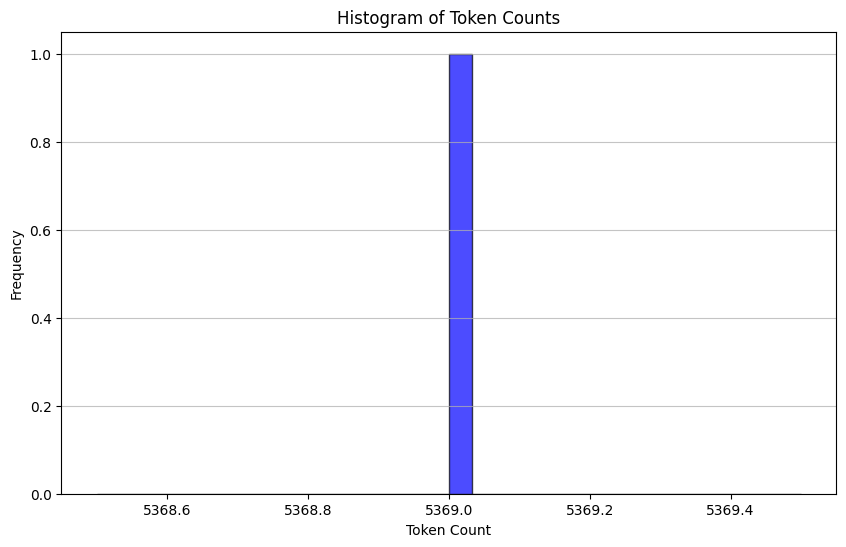

In [9]:
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show()

In [10]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)
#
# Response
# Num tokens in all context: 69108

Num tokens in all context: 5369


In [11]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 1000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)
#
print(f"Number of text splits generated: {len(texts_split)}")
#
# Response
# Number of text splits generated: 142

Number of text splits generated: 10


In [12]:
global_embeddings = [embd.embed_query(txt) for txt in texts_split]
print(len(global_embeddings[0]))
###########
# 384

768


c:\Users\hello\miniconda3\envs\raptor\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[12.897343  -0.7120698]


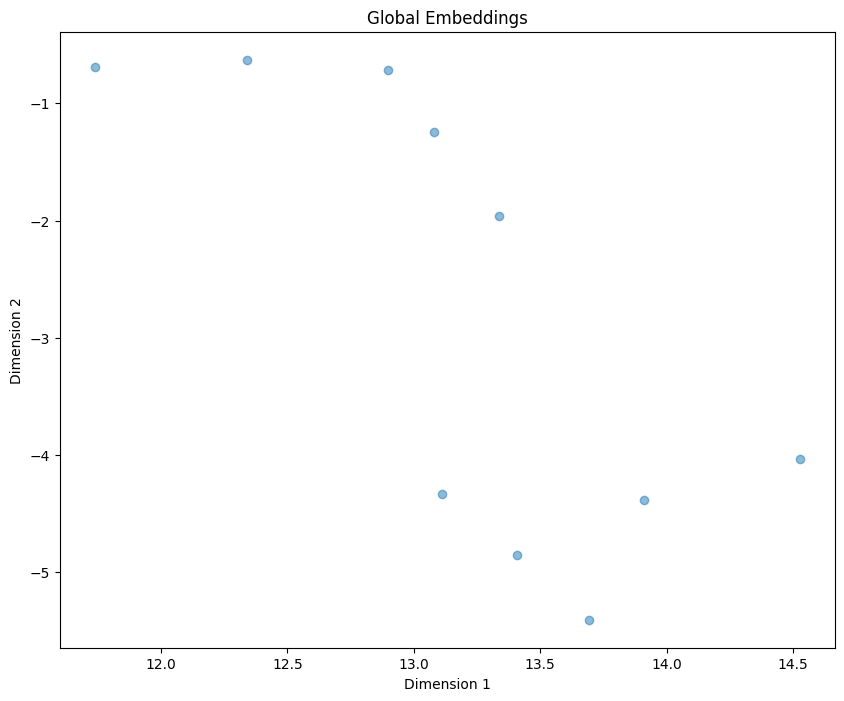

In [13]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
print(global_embeddings_reduced[0])
#
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

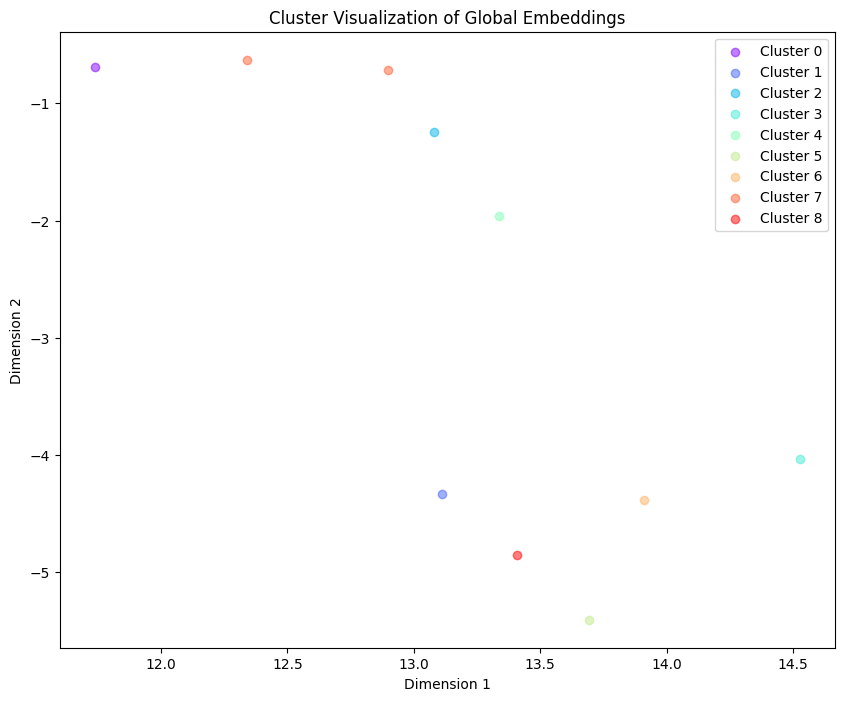

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters
#
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [15]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts_split,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text                Embedding  \
0  Tin tức Trang chủ Tin tức y khoa Bị cảm cúm uố...  [12.897343, -0.7120698]   
1  mũi,... Người cao tuổi, trẻ em, phụ nữ mang th...  [12.339999, -0.6280454]   
2  hiểm đến tính mạng. Nhóm thuốc giúp khắc phục ...   [13.409542, -4.853353]   

   Cluster  
0        7  
1        7  
2        8  


In [16]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts
#
clustered_texts = format_cluster_texts(df)
#
clustered_texts

{np.int64(7): 'Tin tức Trang chủ Tin tức y khoa Bị cảm cúm uống thuốc gì? Các loại thuốc cúm phổ biến hiện nay Bị cảm cúm uống thuốc gì? Các loại thuốc cúm phổ biến hiện nay Ngày 06/06/2023 Cảm cúm là tình trạng thường gặp ở mọi lứa tuổi, xảy ra nhiều nhất trong giai đoạn thời tiết thay đổi. Triệu chứng của cảm cúm thường khiến bệnh nhân mệt mỏi, sổ mũi, đau nhức cơ thể,... ảnh hưởng không nhỏ đến sinh hoạt hàng ngày. Vì thế nên nhiều người đã tìm đến các thuốc điều trị cảm cúm để khắc phục những khó chịu do tình trạng này gây ra. Vậy bị cảm cúm uống thuốc gì để nhanh khỏi? Câu trả lời sẽ được chia sẻ ngay dưới bài viết sau đây. 03/08/2022 Điều trị cảm cúm hiệu quả với thuốc Eugica 16/09/2022 Phân biệt dấu hiệu mắc Adenovirus với bệnh cảm cúm, hô hấp thông thường 07/11/2021 Những điều cần lưu ý về bệnh cảm cúm giao mùa 1. Tìm hiểu chung về bệnh cúm Khi bị cảm cúm , người bệnh thường sẽ có các triệu chứng như hắt hơi, toàn thân đau mỏi, nhức đầu, đau nhức cơ,... Sang đến giai đoạn sau n

In [17]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    # template = """Here is a sub-set of LangChain Expression Langauge doc.

    # LangChain Expression Langauge provides a way to compose chain in LangChain.

    # Give a detailed summary of the documentation provided.

    # Documentation:
    # {context}
    # """

    template = """Đây là một phân đoạn của bài viết về bệnh cảm cúm.

    Bài viết đề cập về cảm cúm và thuốc điều trị bệnh cảm cúm.

    Hãy tóm tắt lại tài liệu được cung cấp.

    Tài liệu:
    {context}
    """

    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [ ]:
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 1 clusters--


c:\Users\hello\miniconda3\envs\raptor\Lib\site-packages\huggingface_hub\utils\_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


In [19]:
# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)
#Final Summaries extracted
print(all_texts)

['Tin tức Trang chủ Tin tức y khoa Bị cảm cúm uống thuốc gì? Các loại thuốc cúm phổ biến hiện nay Bị cảm cúm uống thuốc gì? Các loại thuốc cúm phổ biến hiện nay Ngày 06/06/2023 Cảm cúm là tình trạng thường gặp ở mọi lứa tuổi, xảy ra nhiều nhất trong giai đoạn thời tiết thay đổi. Triệu chứng của cảm cúm thường khiến bệnh nhân mệt mỏi, sổ mũi, đau nhức cơ thể,... ảnh hưởng không nhỏ đến sinh hoạt hàng ngày. Vì thế nên nhiều người đã tìm đến các thuốc điều trị cảm cúm để khắc phục những khó chịu do tình trạng này gây ra. Vậy bị cảm cúm uống thuốc gì để nhanh khỏi? Câu trả lời sẽ được chia sẻ ngay dưới bài viết sau đây. 03/08/2022 Điều trị cảm cúm hiệu quả với thuốc Eugica 16/09/2022 Phân biệt dấu hiệu mắc Adenovirus với bệnh cảm cúm, hô hấp thông thường 07/11/2021 Những điều cần lưu ý về bệnh cảm cúm giao mùa 1. Tìm hiểu chung về bệnh cúm Khi bị cảm cúm , người bệnh thường sẽ có các triệu chứng như hắt hơi, toàn thân đau mỏi, nhức đầu, đau nhức cơ,... Sang đến giai đoạn sau những triệu ch

In [20]:
# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

In [30]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langsmith import Client

# Prompt
# 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
# client = Client(api_key="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")
# prompt = client.pull_prompt("legal_raptor_rag", include_model=True)


prompt = hub.pull("htnghiaaa/legal_raptor_rag")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

c:\Users\hello\miniconda3\envs\raptor\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [31]:
print(prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'htnghiaaa', 'lc_hub_repo': 'legal_raptor_rag', 'lc_hub_commit_hash': '66a17272fa69ea9679aeced66fdd38e0f147f55fb4cc4644f7cf1ab966a8ad07'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Bạn là một chuyên gia trong lĩnh vực trả lời câu hỏi. Hãy sử dụng các tài liệu đã được cung cấp để trả lời câu hỏi, tuyệt đối câu trả lời chỉ được dựa trên các tài liệu được cung cấp. Nếu tài liệu được cung cấp không giúp trả lời được câu hỏi, thì bạn hãy trả lời là bạn không biết. Trả lời tối đa trong 3 câu, và giữ cho câu trả lời ngắn gọn, xúc tích, trả lời bằng tiếng Việt.\n\nQuestion: {question} \nContext: {context} \nAnswer:'), additional_kwargs={})]


In [32]:
print(prompt.messages[0].prompt.template)

Bạn là một chuyên gia trong lĩnh vực trả lời câu hỏi. Hãy sử dụng các tài liệu đã được cung cấp để trả lời câu hỏi, tuyệt đối câu trả lời chỉ được dựa trên các tài liệu được cung cấp. Nếu tài liệu được cung cấp không giúp trả lời được câu hỏi, thì bạn hãy trả lời là bạn không biết. Trả lời tối đa trong 3 câu, và giữ cho câu trả lời ngắn gọn, xúc tích, trả lời bằng tiếng Việt.

Question: {question} 
Context: {context} 
Answer:


In [33]:
# Question
response =rag_chain.invoke("Tôi bị ho nhiều thì nên uống thuốc gì?")
print(str(response))

Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2
c:\Users\hello\miniconda3\envs\raptor\Lib\site-packages\huggingface_hub\utils\_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Human: Bạn là một chuyên gia trong lĩnh vực trả lời câu hỏi. Hãy sử dụng các tài liệu đã được cung cấp để trả lời câu hỏi, tuyệt đối câu trả lời chỉ được dựa trên các tài liệu được cung cấp. Nếu tài liệu được cung cấp không giúp trả lời được câu hỏi, thì bạn hãy trả lời là bạn không biết. Trả lời tối đa trong 3 câu, và giữ cho câu trả lời ngắn gọn, xúc tích, trả lời bằng tiếng Việt.

Question: Tôi bị ho nhiều thì nên uống thuốc gì? 
Context: Tin tức Trang chủ Tin tức y khoa Bị cảm cúm uống thuốc gì? Các loại thuốc cúm phổ biến hiện nay Bị cảm cúm uống thuốc gì? Các loại thuốc cúm phổ biến hiện nay Ngày 06/06/2023 Cảm cúm là tình trạng thường gặp ở mọi lứa tuổi, xảy ra nhiều nhất trong giai đoạn thời tiết thay đổi. Triệu chứng của cảm cúm thường khiến bệnh nhân mệt mỏi, sổ mũi, đau nhức cơ thể,... ảnh hưởng không nhỏ đến sinh hoạt hàng ngày. Vì thế nên nhiều người đã tìm đến các thuốc điều trị cảm cúm để khắc phục những khó chịu do tình trạng này gây ra. Vậy bị cảm cúm uống thuốc gì để 

In [ ]:
# Question
response =rag_chain.invoke("Kể cho tôi nghe về thuốc điều trị đặc hiệu, và một vài tên thuốc")
print(str(response))